## 0. Bibliotecas e dados de entrada

In [ ]:
# Bibliotecas
!pip install -q rasterio
!pip install -q gdown

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import gdown

In [ ]:
# Imagem Sentinel-2
gdown.download(f'https://drive.google.com/uc?id=1YFllRJNqgS3qzU9fQB18BxVwYY4v31E8', 'S2.tif', quiet=True)

'S2.tif'

In [ ]:
# Polígonos de treinamento/teste
gdown.download(f'https://drive.google.com/uc?id=1vtqVjDLcnyeKe3m9GXaifyIyXg8H1pUS', 'TA.gpkg', quiet=True)

'TA.gpkg'

## 1. Carregar dados e figuras exploratórias

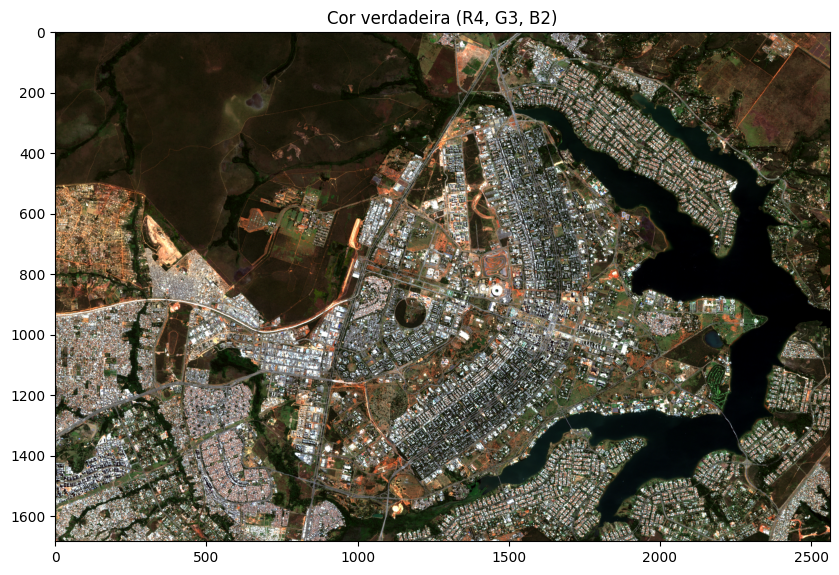

In [ ]:
# Bandas:
# 1 - Azul
# 2 - Verde
# 3 - Vermelho
# 4 - Red edge 1
# 5 - Red edge 2
# 6 - Red edge 3
# 7 - Infra. próximo
# 8 - Red edge 4

# Plotar a imagem
s2 = rasterio.open('S2.tif')

def stretch_band(band, pmin=2, pmax=98):
    vmin, vmax = np.percentile(band[np.isfinite(band)], (pmin, pmax))
    band_stretched = np.clip((band - vmin) / (vmax - vmin), 0, 1)
    return band_stretched

r = stretch_band(s2.read(3).astype(float))
g = stretch_band(s2.read(2).astype(float))
b = stretch_band(s2.read(1).astype(float))

rgb = np.dstack([r, g, b])

plt.figure(figsize=(10, 10))
plt.imshow(rgb)
plt.title('Cor verdadeira (R4, G3, B2)')
# plt.axis('off')
plt.show()

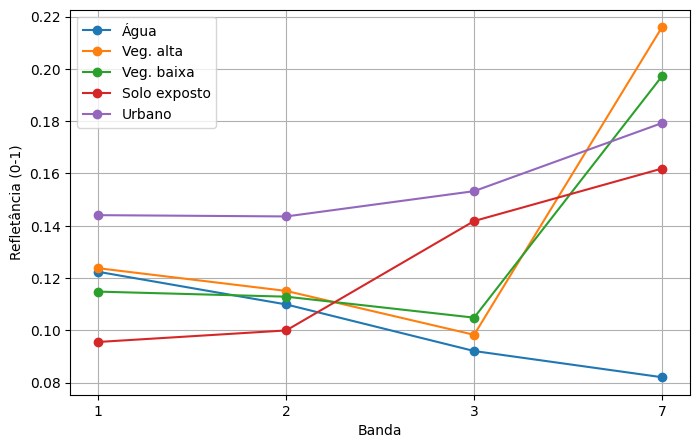

In [ ]:
# Carregar polígonos de treino/teste
ta = gpd.read_file('TA.gpkg')

# Classes:
# 1 = Água
# 2 = Vegetação alta
# 3 = Vegetação baixa
# 4 = Solo exposto
# 5 = Área urbana
class_index = {1: 'Água', 2: 'Veg. alta', 3: 'Veg. baixa', 4: 'Solo exposto', 5: 'Urbano'}

classes = sorted(ta['class'].unique())

bands = [1, 2, 3, 7] # Bandas 2 (B), 3 (G), 4 (R) e 8 (IR)
# bands = list(range(1, 9)) # Todas as bandas

band_refl = {cls: [] for cls in classes}

for cls in classes:
    subset = ta[ta['class'] == cls]
    all_band_refl = []

    for b in bands:
        band_data = []
        for geom in subset.geometry:
            out_img, out_transform = mask(s2, [mapping(geom)], crop=True, indexes=b)
            data = out_img[out_img != s2.nodata]
            if len(data) > 0:
                band_data.append(data.mean())
        if len(band_data) > 0:
            all_band_refl.append(np.mean(band_data))
        else:
            all_band_refl.append(np.nan)
    band_refl[cls] = all_band_refl

plt.figure(figsize=(8, 5))

for cls, refl in band_refl.items():
    plt.plot(range(1, len(bands)+1), refl, marker='o', label=class_index[cls])

plt.xlabel('Banda')
plt.ylabel('Refletância (0-1)')
plt.xticks(range(1, len(bands)+1), bands)
plt.legend(loc='best')
plt.grid(True)
plt.show()

## 2. SVM com Kernel linear

In [ ]:
# Converter X para uma matrix m x n e Y para um vetor
X = []
Y = []

bands_len = len(bands)

for idx, row in ta.iterrows():
    geom = [mapping(row.geometry)]
    out_data, out_transform = mask(s2, geom, crop=True, indexes=bands)
    mask_array = out_data != s2.nodata
    pixels = out_data.reshape(bands_len, -1).T
    valid_pixels = pixels[np.all(mask_array.reshape(bands_len, -1).T, axis=1)]
    X.append(valid_pixels)
    Y.append(np.full(valid_pixels.shape[0], row['class']))

X = np.vstack(X)
Y = np.hstack(Y)

print(f'Amostras: {X.shape[0]}, Bandas: {X.shape[1]}')

# Dividir dados entre treino e teste
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# Normalização Z-score
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Treinar SVM
svm = SVC(kernel='linear')
svm.fit(X_train_scaled, Y_train)

# Calcular acurácia
ac = svm.score(X_test_scaled, Y_test)
print(f"Acurácia: {ac:.3f}")

Amostras: 18002, Bandas: 4
Acurácia: 0.835


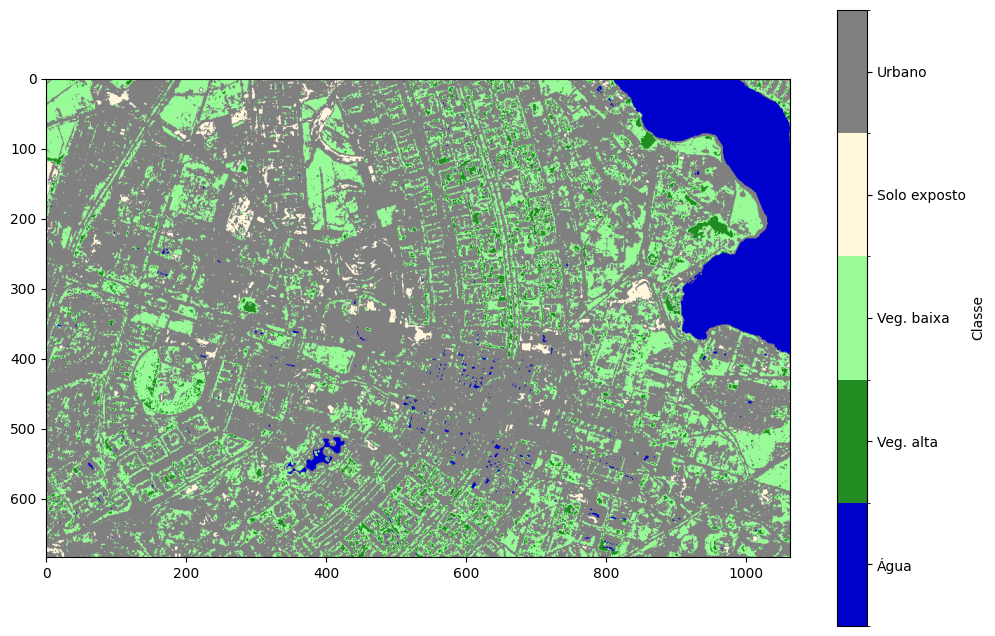

In [ ]:
# Classificar raster

# Recorte
window = ((500, s2.height - 500), (1000, s2.width - 500))
img = s2.read(window=window, indexes=bands).transpose(1, 2, 0)

# Máscara, normalização e classificação
s2_mask = (img != s2.nodata).all(axis=2)
s2_flat = img[s2_mask]
pred = svm.predict(scaler.transform(s2_flat))

classified = np.zeros(s2_mask.shape, dtype=np.uint8)
classified[s2_mask] = pred.astype(np.uint8)

# Plotar resultados
cmap = ListedColormap(['mediumblue', 'forestgreen', 'palegreen', 'cornsilk', 'gray'])
norm = BoundaryNorm(np.arange(1, 7), cmap.N)
plt.figure(figsize=(12, 8))
plt.imshow(classified, cmap=cmap, norm=norm)
plt.colorbar(ticks=np.arange(1.5, 6.5),
             label='Classe',
             ax=plt.gca()).ax.set_yticklabels(['Água', 'Veg. alta', 'Veg. baixa', 'Solo exposto', 'Urbano'])
plt.show()

## 3. SVM com Kernel não-linear